In [ ]:
# https://keras.io/examples/nlp/text_classification_with_transformer/
# https://github.com/tensorflow/tensor2tensor# See available GPU RAM 
!nvidia-smi # can also be run from linux shell while GPU is training
# !nvidia-smi dmon # this will stream memory utilisation
# !htop # cpu threads and if they're all working

In [ ]:
!python3 -m pip install tensorflow==2.1.0

In [1]:
# This cell has the latest set up for AI Platform

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import glob
import cv2
from io import BytesIO
from PIL import Image
from numpy import expand_dims
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import *
import warnings
import logging
from IPython.display import clear_output
from collections import Counter
import pickle
import sys
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/visualisations')
import VisualisationTools as plotting

import TransformCode as tc

warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(100)
plot_losses = plotting.PlotLearning()
os.chdir('/home/jupyter/DeepFake-2019-20')


print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0-dlenv


In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [3]:
embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = tc.TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = tc.TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_text = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model_text.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           646400    
_________________________________________________________________
transformer_block (Transform (None, 200, 32)           6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

Following [3], we do not fine-tune the network. 
The 2048-dimensional feature vec- tors after the last pooling layers are then used as the sequen- tial LSTM input.

The key challenge that we need to address is the de- sign of a model to recursively process a sequence in a mean- ingful manner. For this problem, we resort to the use of a 2048-wide LSTM unit with 0.5 chance of dropout, which is capable to do exactly what we need. More particularly, during training, our LSTM model takes a sequence of 2048- dimensional ImageNet feature vectors. The LSTM is followed by a 512 fully-connected layer with 0.5 chance of dropout. Then classic dropout, no auxiliary loss functions are necessary (but might be interesting right).

The optimizer is set to Adam[23] for end-to-endtraining of the complete model with a learning rate of 1e−5 and decay of 1e−6.


In [5]:
#model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
#history = model.fit(
#    x_train, y_train, batch_size=32, epochs=4, validation_data=(x_val, y_val)
#)

In [2]:
def build_model(dropout, lr_rate, architecture = 'lstm'):
    frames = 10
    channels = 3
    rows = 224
    columns = 224
    
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    
    video = tf.keras.layers.Input(shape=(frames,
                         rows,
                         columns,
                         channels,))
    
    
    if architecture == 'lstm':
        
        from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
        conv_base = MobileNetV2(weights='imagenet', include_top=False,
                            input_shape=(224,224,3))
    
        cnn_out = GlobalAveragePooling2D()(conv_base.output)
        cnn = keras.Model(inputs=conv_base.input, outputs=cnn_out)
        cnn.trainable = False
    
        encoded_frames = tf.keras.layers.TimeDistributed(cnn)(video)
        
        encoded_sequence = tf.keras.layers.LSTM(256)(encoded_frames)
        hidden_layer = Dense(128, activation="relu")(encoded_sequence)
        outputs = Dense(2, activation="softmax")(hidden_layer)
        model = Model([video], outputs)
    
        
    if architecture == 'transformer':
        
        embedding_layer = tc.TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        x = embedding_layer(cnn.output)
        transformer_block = tc.TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(20, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
        model = Model([video], outputs)
                
        
    
    optimizer = tf.keras.optimizers.Nadam(lr=lr_rate,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      schedule_decay=0.004)
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["binary_accuracy"]) 
    return model
    

In [51]:
from tweaked_ImageGenerator_v2 import ImageDataGenerator
def augment_data(directory, batch):
    '''Prepares train-time augmentation using given training and validations data)
    
    Returns train_data, val_data'''

    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=True,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=True,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            )

#     # Classes give the folders storing the two different categories
#     train_data = datagen.flow_from_directory(directory + '/train',
#                                              target_size=(224,224), batch_size = batch,
#                                             frames_per_step=15, shuffle = True)
    
#     val_data = datagen.flow_from_directory(directory + '/validation',
#                                              target_size=(224,224), batch_size = batch,
#                                           frames_per_step=15, shuffle = True)

    # Classes give the folders storing the two different categories
    train_data = datagen.flow_from_directory(directory + '/train/authentic',
                                             target_size=(224,224), batch_size = batch,classes=['Original_001','Original_002'],
                                            frames_per_step=15, shuffle = True)
    
    val_data = datagen.flow_from_directory(directory + '/validation',
                                             target_size=(224,224), batch_size = batch,
                                          frames_per_step=15, shuffle = True)
    
    return train_data

In [52]:
batch = 4
train_data = augment_data('../restructured-all-faces/home/jupyter/restructured_data', batch)
# train_data = augment_data('../all_faces_disk/home/jupyter/forensics_split', batch)
# !pwd

Found 78 images belonging to 2 classes.
Found 21292 images belonging to 2 classes.


In [22]:
# for i,j in enumerate(train_data):
#     print(j)
#     if i==5:
#         break

# b=[]
# c=0
# for i in train_data:
#     for j in i:
#         b.append(j)
#         c+=1
#         if c==4:
#             break
#     break
    
# # bb = np.array(b)

# np.array(b).shape
b[0].shape

(60, 15, 224, 224, 3)

In [53]:
b=[]
c=0
for i in train_data:
    b.append(i[0])
    c+=1
    if c==4:
        break
print(b[0].shape)
np.array(b).shape

(60, 15, 224, 224, 3)


(4,)

In [70]:
b[0].shape

(60, 15, 224, 224, 3)

In [50]:
# b=[]
# c=0
# for i in train_data:
#     b.append(i[0])
#     c+=1
#     if c==4:
#         break
print(b[0].shape)
np.array(b).shape

(60, 15, 224, 224, 3)


(4, 60, 15, 224, 224, 3)

In [8]:
t,v = augment_data('../restructured_data', batch)

Found 113929 images belonging to 2 classes.
Found 21291 images belonging to 2 classes.


In [14]:
t.class_mode

'categorical'

In [4]:
def calculate_class_weights(train_data):
    '''Calculates class weights that weight the data based on the imbalance.
    Allows for better analysis in the case of imbalanced data - has no effect
    if data is balanced since the weights are then equal for each class.
    Use the generator obtained from the flow_from_directory method to obtain
    the class_weights.
    
    Input:
    train_data: the generator obtained during augmentation
    
    Returns a dictionary with class weights, required format for training'''
    
    # Calculate class weights which are required to fully balance the classes
    # Compares frequencies of appearence for each distinct label
    
    # The line of code below can be used on a generator to find the index labels
    print('Ensure class weights function corresponds to these class indices:',
          train_data.class_indices)
    
    counter = Counter(train_data.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

    return class_weights

In [5]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
with strategy.scope(): # Everything that creates variables should be under the strategy scope.
    model = build_model(0.1,0.002)
print(model.summary())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localh

In [6]:
batch = 4

train_data, val_data = augment_data('../restructured_data', batch)

class_weights = calculate_class_weights(train_data)

Found 113929 images belonging to 2 classes.
Found 21291 images belonging to 2 classes.
Ensure class weights function corresponds to these class indices: {'authentic': 0, 'fake': 1}


<Figure size 432x288 with 0 Axes>

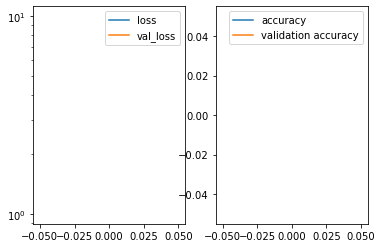

    1/28482 [..............................] - ETA: 185:01:43

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Incompatible shapes: [60,2] vs. [90,2]
	 [[node metrics/binary_accuracy/Equal (defined at /opt/conda/lib/python3.7/threading.py:926) ]]
	 [[Identity_4/_58]]
  (1) Invalid argument:  Incompatible shapes: [60,2] vs. [90,2]
	 [[node metrics/binary_accuracy/Equal (defined at /opt/conda/lib/python3.7/threading.py:926) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_23600]

Errors may have originated from an input operation.
Input Source operations connected to node metrics/binary_accuracy/Equal:
 cond_1/Identity_1 (defined at <ipython-input-7-fe90236a01c6>:11)

Input Source operations connected to node metrics/binary_accuracy/Equal:
 cond_1/Identity_1 (defined at <ipython-input-7-fe90236a01c6>:11)

Function call stack:
distributed_function -> distributed_function


In [7]:
epochs = 3
history = model.fit(train_data, epochs=epochs, shuffle=True,
              steps_per_epoch = train_data.n//train_data.batch_size,
              validation_data = val_data, 
              validation_steps = val_data.n//val_data.batch_size,
              class_weight=class_weights,
              callbacks=[plot_losses],
              verbose=1,
              max_queue_size=30,                # maximum size for the generator queue
              workers=16,                        # maximum number of processes to spin up when using process-based threading
              use_multiprocessing=False)

In [ ]:
def save_model_from_best_weights(dropout, lr_rate, architecture):
    '''Takes the latest saved weights and saves the corresponding model.'''
    model = build_model(dropout, lr_rate, architecture)
    load_model_weights(model, architecture)
    model.save('../all_faces_bucket/trained_models/saved_models/' + architecture + '_model.h5')    

In [ ]:
def train_model(model, train_data, val_data, epochs, class_weights, architecture):
    '''Trains a provided model.
    Takes 6 arguments:
    
    1. model: a built model with an architecture specified in the build function
    2. train_data: augmented data obtained from the augment_data function
    3. val_data: validation data obtained from the augment_data function
    4. epochs -- number of epochs
    5. class weights -- a dictionary with weights (equal for balanced data so
    no negative impact)
    6. architecture: can choose vgg, xception, resnet50, mobilenet or efficientnet
    '''
    
    # Make a trained_models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models'):
        os.makedirs('../all_faces_bucket/trained_models')
    
    # Make a weights folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights'):
        os.makedirs('../all_faces_bucket/trained_models/weights')
        
    # Make a weights folder for the architecture if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights/' + architecture):
        os.makedirs('../all_faces_bucket/trained_models/weights/' + architecture)

    # Save weights - below saves every epoch where there is improvement
    # filepath="../all_faces_bucket/trained_models/weights/" + architecture + "/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
    # Below saves on file - the weights with the highest validation accuracy
    filepath="../all_faces_bucket/trained_models/weights/" + architecture + "/highest_val_acc.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                verbose=1, save_best_only=True, mode='max')
    
    # Make a folder to store training accuracies if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/training_accuracies'):
        os.makedirs('../all_faces_bucket/trained_models/training_accuracies')
    
    # Callback to save training accuracies after each epoch
    csv_logger = CSVLogger('../all_faces_bucket/trained_models/training_accuracies/' + architecture + ".csv",
                           separator=',', append=True)
    
    # Stop after 3 epochs if val_accuracy doesn't improve
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)
                          
    # Load previous weights from training if there are any
    #load_model_weights(model, architecture)

    history = model.fit(train_data, epochs=epochs, shuffle=True,
              steps_per_epoch = train_data.n//train_data.batch_size,
              validation_data = val_data, 
              validation_steps = val_data.n//val_data.batch_size,
              class_weight=class_weights,
              callbacks=[plot_losses, checkpoint, csv_logger, es],
              verbose=1,
              max_queue_size=30,                # maximum size for the generator queue
              workers=16,                        # maximum number of processes to spin up when using process-based threading
              use_multiprocessing=False)
    
    # Make a saved models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/saved_models'):
        os.makedirs('../all_faces_bucket/trained_models/saved_models')

In [ ]:
def run_training(dropout = 0.5, lr_rate = 0.0001, architecture = 'vgg', 
                 batch = 32, epochs = 50):

    '''Builds a model based on the specified architecture, augments training
    data (reserving a fraction for validation), then computes class weights to
    balance data and trains the model.
    
    Inputs:
    1. dropout  -- for the model
    2. lr_rate
    3. architecture -- a choice of vgg, resnet50, mobilenet, xception and efficientnet
    4. batch -- batch size
    5. epochs -- number of epochs
    '''

    # Build a model, augment data, get class_weights and train the model
    # Strategy scope allows us to leverage multiple GPUs
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    with strategy.scope(): # Everything that creates variables should be under the strategy scope.
        model = build_model(dropout, lr_rate, architecture)
    print(model.summary())
    train_data, val_data = augment_data('../all_faces_disk/home/jupyter/forensics_split', batch)
    class_weights = calculate_class_weights(train_data)
    trained_model = train_model(model, train_data, val_data, epochs, class_weights, architecture)

In [ ]:
run_training(dropout = 0.1, lr_rate = 0.0002, batch = 32, epochs = 100)